# In class exercises for ML tutorials, 11.01.2021

## Read in data from eeg study
* This time I've kept in data across a 1s window from many electrodes (20) sampled at 250Hz, so now we have a [960, 20, 250] matrix that contains data from all 960 trials, 20 electrodes, and over a 1s window following stimulus onset
* Also read in a "cond_labels" vector that has 960 0's and 1's to mark trials from the two experimental conditions 

### Hints and tips...
* Pay careful attention to the dimension that you are operating over when you take the mean, etc. Make use the "axis" param!
* When plotting, the size of the first axis of your "x" data must match the size of the first axis of your "y" data. The ".T" method will transpose a numpy array, or swap the first and second dimensions. E.g., if my_array.shape is 200,10, then my_array.T will be of shape 10,200. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# Support vector classifier
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score

In [2]:
# load the data...
eeg = np.load('class_demo_eeg.npz')

# get the different arrays like this...
eeg['data']
eeg['sr']
eeg['tx']
eeg['cond_labels']

# shape of data
print('Shape of the big eeg data set: ', eeg['data'].shape)

# and if you want to save some typing, especially because we only have a few variables, you reassign the different arrays like this
data = eeg['data']
sr = eeg['sr']
tx = eeg['tx']
cond_labels = eeg['cond_labels']


Shape of the big eeg data set:  (960, 20, 250)


## Compute the mean across the first dimension (trials) and then plot the mean response across time in each of the 20 electrodes on one axis

* May need to transpose the data when you plot such that time runs down the columns
* Put labels on the axes

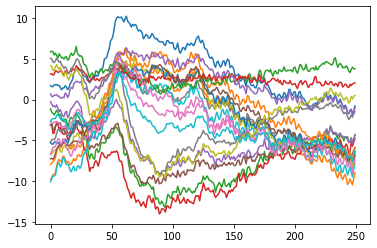

In [16]:
m = np.mean(data,axis=0)
# for e in range(20):
#     plt.plot(m[e,:])
plt.plot(m.T)
plt.show()

## That gives you an idea about what the pattern of data looks like across electrodes. 
* Next, take the mean across time separately in each electrode, so you should end up with a 960 x 20 matrix 
* Use the cond_labels vector to sort the data based on condition (so you have two 480 x 20 matrices), one matrix for each experimental condition.
* Take 90% (or thereabouts) of the data from each condition and use that as a training set. Use the remaining 10% of data from each condition as a test set. 
* Do classification to see if you can decode the experimental condition - train the model on your "training" data, and then test on the held out 10% from each condition.

In [28]:
m = np.mean(data,axis=2)
m.shape

(960, 20)

In [32]:
d_c1 = m[(cond_labels==0),:]
d_c2 = m[(cond_labels==1),:]
d_c1.shape

(480, 20)

In [33]:
# first lets assign parts of our data to training and testing sets
percent_train_set = .9
r,c = d_c1.shape  # get the shape of our data sets (they are the same size, so can just do this once)
trn_length = int(np.round(percent_train_set * r, 0))

# now assign the first 90% of the trials to the training set...
# we'll stack up the first 90% from the first condition on top 
# of the 90% of data from the second condition
trn_data = np.vstack((d_c1[0:trn_length,:], d_c2[0:trn_length,:]))

# and the last 10% of the trials get stacked to make the test set...
tst_data = np.vstack((d_c1[trn_length:,:], d_c2[trn_length:,:]))

# last generate a vector that labels the data from each trial
# as belonging to condition 1 or condition 2
trn_labels = np.hstack((np.zeros(trn_length), np.ones(trn_length))).T
tst_labels = np.hstack((np.zeros(r-trn_length), np.ones(r-trn_length))).T

# The SVC was imported earlier via the sklearn module
# so we can train the classifer using our data.

# first specify the model...linear SVM with a criterion value of 1
# if C is big, that will enforce a hard margin...if C is small, it 
# will allow some leakage of points over the margin.
model = SVC(kernel='linear', C=1)

# then fit the model to our training data by passing in the data matrix + a list of labels that denotes the 
# experimental condition for each trial
model.fit(trn_data, trn_labels)

SVC(C=1, kernel='linear')

In [37]:
# then classify the test trials
class_labels = model.predict(tst_data)

# Then just compute our classification accuracy by comparing the predicted labels to the ground truth
class_acc = np.sum(class_labels==tst_labels) /  tst_data.shape[0]
print('Classification accuracy with a SVM is: ', class_acc)

# or use built in....takes actual and then predicted labels...
accuracy_score(tst_labels, class_labels)

Classification accuracy with a SVM is:  0.5520833333333334


0.5520833333333334

## Now try doing this across timepoints!
* First do a time window based on where you think there is nice separation in the responses across electrodes (look at the data that you plotted above)...maybe try 300-400msec post stim and a few others...
* Bonus on your own: try timepoint x timepoint or a **moving window** (e.g. a series of 10ms bins)

In [42]:
data_window = np.mean(data[:,:,(tx >=300)&(tx<400)],axis=2)

In [43]:
data_window

array([[  6.1872448 ,   9.99675096, -12.21418161, ..., -16.53976553,
        -15.22045442,  -1.28763876],
       [ 11.4981352 ,  10.15881735, -21.48551473, ...,  -8.48388373,
         -5.62932437,   8.54617594],
       [ 15.85308301,  23.5769699 ,   8.3965211 , ...,  21.32187534,
         17.92753475,  24.85116307],
       ...,
       [  3.42612417,  19.31719207, -15.17466986, ...,   0.65587606,
          3.25539115,   0.33390861],
       [ 15.26413041,  25.53534593,  -7.65415669, ...,   6.36099417,
          2.4217804 ,  18.4324031 ],
       [ 19.75673632,  22.23409192,   6.54404835, ...,  25.61635813,
         20.62629384,  16.89035778]])